## IMHOTEP: SSS Timeseries, ensemble mean, and variability 
Notebook to:
1. Load data from an ensemble experiment over a selected region and at a selected point
2. Compute its ensemble mean, std, spatial avera  
3. Plot timeseries of each member of the experiment at the selective point 
4. Plot timeseries of SSS ensemble mean and spread of the experiment at the selective point
5. Plot timeseries of SSS for each member, ensemble mean and spread of the experiment at the selective point
6. Check the sum of variances (forced, intrinsic and total variability)


#### Import modules

In [3]:
# standard libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

import cartopy.feature as cfeature

import cmocean

import pkg_resources


# custom tools for plotting
sys.path.append('./')
from libimhotep import libSLXtoolsIMHOTEP as li
from libimhotep import pltscripts as pltGLO

plt.rcParams.update({'hatch.color': '#086A87'})

# for jupyter notebook display
%matplotlib inline

ModuleNotFoundError: No module named 'libimhotep'

### **1.  Load data from an ensemble experiment over a selected region and at a selected point**

#### Parameters of the experiment

In [2]:
# ES: this is experiment ES (ensemble simulation) of which we will load all the 10 members
nexp = "ES"

prefix = "eORCA025.L75-IMHOTEP"



# frequency of the input files
fo="1y"

# name of the variable
varnasss = 'sosaline'

# file type
fileType = "gridTsurf"

# period over which to read
y1='1980'
y2='2018'

# ensemble size
NE=10

# input directory on work for grid info
#diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
dirigrid = '/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/'

# plot directory !!!! CREATE THIS DIRECTORY FIRST ON JEAN ZAY IF DOESNT EXIST YET
diro="/gpfswork/rech/cli/regi915/PLT/2023-05/"+fo+"/"

# data output directory   !!!! CREATE THIS DIRECTORY FIRST ON JEAN ZAY IF DOESNT EXIST YET
dirdat="/gpfswork/rech/cli/regi915/DAT/"



#### Load data over a selected region

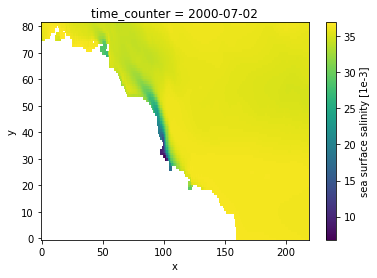

In [3]:
# x and y indices you want to select the region over.
xselect=[850,1069]
yselect=[654,736]


# The function 'Floadmultimb' load data from NE ensemble members on a selected subregion
regdata = li.Floadmultimb(NE,nexp,prefix,varnasss,fo,fileType,y1,y2,xselect=[850,1069],yselect=[654,736],verbose=False)

# quick plot as a check 
regdata.isel(e=0,time_counter=20).plot()


CONSTRUCTION : lat et lon à la place de x et y

In [2]:
dirigrid = '/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/'
lat = xr.open_dataset(dirigrid+'mesh_hgr.nc')['nav_lat']
lon = xr.open_dataset(dirigrid+'mesh_hgr.nc')['nav_lon']   
mask = xr.open_dataset(dirigrid+'mesh_hgr.nc')['tmask'][0,0,:,:]

NameError: name 'xr' is not defined

In [ ]:

# user's parameters:
# levels over which to plot the ocean variable [min, max, increment values]
lev = [21, 39, 0.5]
    
# predifined region over which to plot:  'GLO' 'gro' 'atl' 'tropatl' 'asia' 'ind' 'bof'
# 'GLO' for global plot
reg='atl'
    
    
#set default grid parameters before plotting
pltgridparam = li.Fpltgridparamdefaults(reg=reg)
pltgridparam['axextent']=[-100,20,-11,41]
pltgridparam['minlat']=pltgridparam['axextent'][2]
pltgridparam['minlat']=pltgridparam['axextent'][3]
print('- pltgridparam')
print(pltgridparam)

# set default color parameters before plotting
pltcolparam = li.Fpltsetcolorsdefaults('TM')
if (lev=='def'):
    pass
else:
    pltcolparam['levbounds']= lev
if (cbincr=='def'):
    pass
else:
    pltcolparam['cbincr']= cbincr


In [ ]:
data2plot  = data2plot.where(mask!=0).squeeze()  
m2plt      = mask.where(mask==0)

#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= CREATE COLORMAP
cmap,norm,levels = li.Fmycolormap(pltcolparam['levbounds'],cm_base=pltcolparam['cm_base'],cu=pltcolparam['cu'],co=pltcolparam['co']) ##080449

#========= DATA SYSTEM PROJECTION (USE PlateCarre if coordinates are in lon, lat)
trdata  = ccrs.PlateCarree() 

#========= DEAL WITH PROJECTION DEPENDING ON IF TARGET IS GLOBAL MAP OR REGIONAL MAP
if (reg=='GLO'):
        ax = plt.axes(projection= ccrs.Mercator(central_longitude=pltgridparam['loncentr'],min_latitude=pltgridparam['minlat'], max_latitude=pltgridparam['maxlat'], globe=None))
else:
        ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=pltgridparam['loncentr']))

#========= THIS IS WHERE THE MODEL VARIABLE (SUCH AS SSS) IS ACTUALLY PLOTTED        
cs   = plt.pcolormesh(lon.squeeze(), lat.squeeze(), data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)


#========= GREY SHADING ON CONTINENTS
# add grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
r=pltcolparam['rgb'][0];g=pltcolparam['rgb'][1];b=pltcolparam['rgb'][2]
# color for continents from data based (hi-res)
onecohrml=pltcolparam['onecohrml']
alphaland=pltcolparam['alphaland']
# add on plot
csland  = plt.pcolormesh(lon.squeeze(), lat.squeeze(), m2plt, shading='flat',cmap=li.Fmake_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)


#========= ADD GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = li.Fpltaddfeatures(ax,pltgridparam['incrgridlon'],pltgridparam['incrgridlat'],onecohrml=pltcolparam['onecohrml'],alphaland=pltcolparam['alphaland'],reg=pltgridparam['reg'],landedgeco=pltcolparam['landedgeco'])  ##585858#BDBDBD

#========= SET FRAME AND GEOGRAPHICAL PLOT EXTENT
if (reg=='GLO'):
        li.Fnospines(ax)
else:
        # geographical limits
        ax.set_extent([pltgridparam['axextent'][0],pltgridparam['axextent'][1],pltgridparam['axextent'][2],pltgridparam['axextent'][3]])
        # remove spines from around plot
        li.Fnospines(ax)


        
plt.show()

#### Select data at a grid point near the Amazone mouth

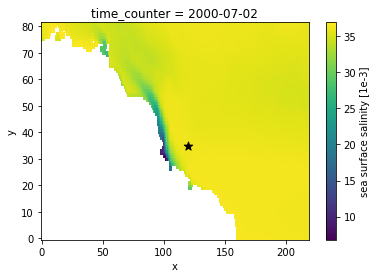

In [5]:
# lets select those indices (x,y)
ijgp = [120,35]

# quick plot as a check
regdata.isel(e=0,time_counter=20).plot()

# add star at point location:
plt.scatter(ijgp[0], ijgp[1], s=80, marker='*',color='k')

### **2. Compute data and its ensemble mean and std at this point**

In [6]:
# x and y parameters: we select a point 
Dot = regdata.isel(x=120,y=35).compute()

In [7]:
# compute ensemble mean and ensemble std over the 10 members 
em = Dot.mean(dim='e').compute()
estd = Dot.std(dim='e').compute()

In [8]:
# compute the spread of the ensemble mean
estdMAX = em+2*estd
estdMIN = em-2*estd

### **3. Plot timeseries of SSS for each member of the experiment at the selective point**

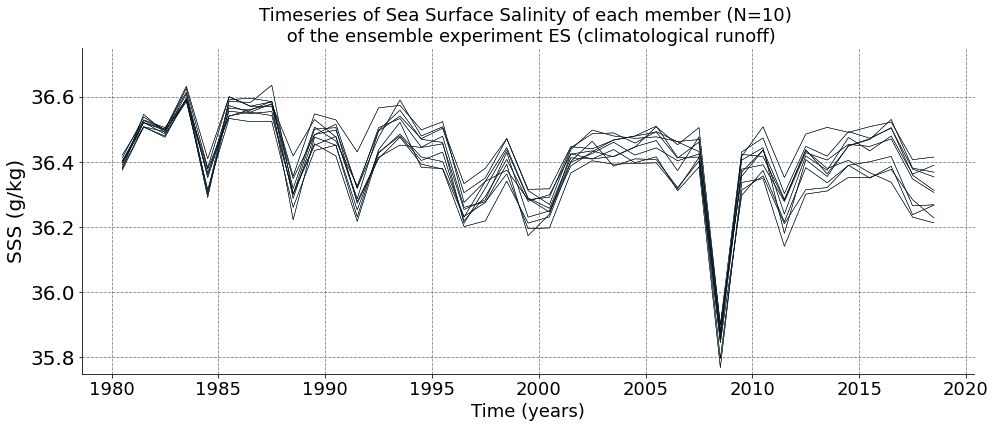

In [30]:
# name of the saved file in case you want to save it 
namo="DOTMEAN_Nao"+"_"+nexp
gp = 0
NGP=5

#-------------
# start plot by creating an empty figure
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  

#-------------
# plot 
# color 1 (pick your own html code from https://htmlcolorcodes.com/)
c1="#154360"

# defined label top appear on plot
la=nexp


#plot timeseries of SSS of each member
for i in range(len(Dot)):
    Dot.isel(e=i).squeeze().plot(linewidth=0.5,color=c1,label=la)
    Dot.isel(e=i).squeeze().plot(linewidth=0.5,color='k')
    
# now customize plot
ax = plt.gca()    

# plot grid
ax.grid(which='both', color='grey', linestyle='--')

# Choose which  lines of the plot frame will appear. 
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

# axis label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

# decide if axis ticks are inside or outside plot frame
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')

# rotate ticks with an angle
plt.xticks(rotation=0, ha='center',va="top")

# axis labels
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

# add legend and choose where it will appear
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Exp:', loc='lower left')

# set the limits of the plot on y axis
plt.ylim(35.75,36.75)

# plot title
plt.title('Timeseries of Sea Surface Salinity of each member (N='+str(NE)+') \n of the ensemble experiment '+nexp+' (climatological runoff)',fontsize=18, loc='center')

# display plot in notebook window
plt.show()

#--------------------
# Save fig in png, resolution dpi    
#li.Fsaveplt(fig1,diro,namo,dpifig=300)


### **4. Plot timeseries of SSS ensemble mean and spread of the experiment at the selective point**

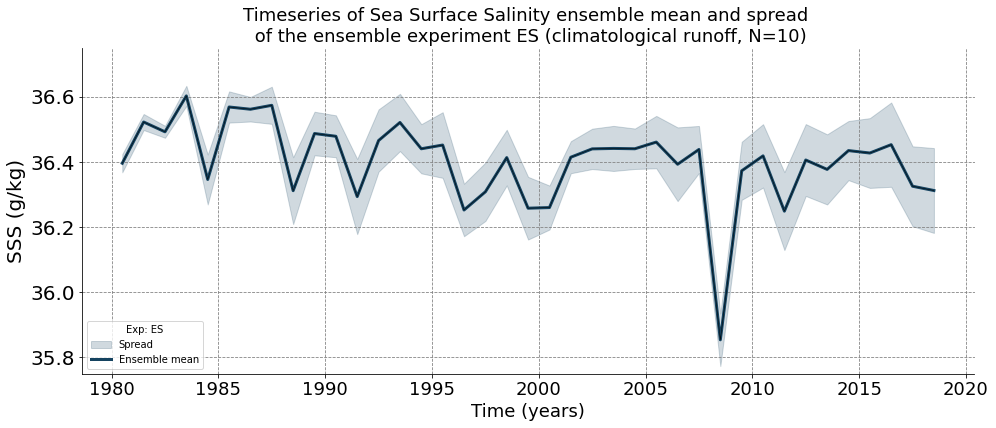

In [31]:
# name of the saved file in case you want to save it 
namo="DOTMEAN_Nao"+"_"+nexp
gp = 0
NGP=5

#-------------
# start plot by creating an empty figure
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  

#-------------
# plot 
# color 1 (pick your own html code from https://htmlcolorcodes.com/)
c1="#154360"

# defined label top appear on plot
la=nexp

# plot shading between lines for ensemble mean - 2x ensemble std and ensemble mean + 2x ensemble std
plt.fill_between(em.time_counter,estdMIN,estdMAX,color=c1,alpha=0.2, label='Spread' )

# plot ensemble mean
Dot.mean(dim='e').squeeze().plot(linewidth=3,color=c1,label='Ensemble mean')
Dot.mean(dim='e').squeeze().plot(linewidth=0.5,color='k')

# now customize plot
ax = plt.gca()    

# plot grid
ax.grid(which='both', color='grey', linestyle='--')

# Choose which  lines of the plot frame will appear. 
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

# axis label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

# decide if axis ticks are inside or outside plot frame
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')

# rotate ticks with an angle
plt.xticks(rotation=0, ha='center',va="top")

# axis labels
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

# add legend and choose where it will appear
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exp: '+nexp, loc='lower left')

# set the limits of the plot on y axis
plt.ylim(35.75,36.75)

# empty plot title
plt.title('Timeseries of Sea Surface Salinity ensemble mean and spread \n of the ensemble experiment '+nexp+' (climatological runoff, N='+str(NE)+')',fontsize=18)

# display plot in notebook window
plt.show()

#--------------------
# Save fig in png, resolution dpi    
#li.Fsaveplt(fig1,diro,namo,dpifig=300)


### **5. Plot timeseries of SSS for each member, ensemble mean and spread of the experiment at the selective point**

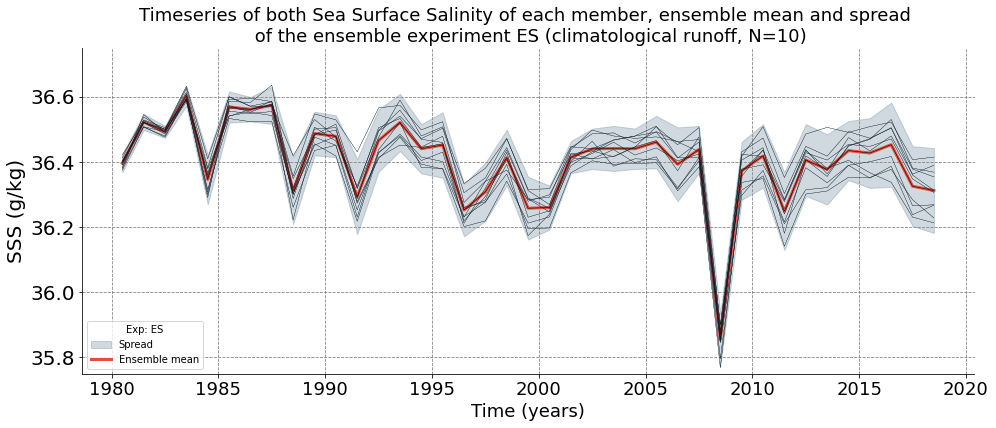

In [32]:
# name of the saved file in case you want to save it 
namo="DOTMEAN_Nao"+"_"+nexp
gp = 0
NGP=5

#-------------
# start plot by creating an empty figure
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  

#-------------
# plot 
# color 1 (pick your own html code from https://htmlcolorcodes.com/)
c1="#154360"
c2= "#e74c3c"

# defined label top appear on plot
la=nexp

# plot shading between lines for ensemble mean - 2x ensemble std and ensemble mean + 2x ensemble std
plt.fill_between(em.time_counter,estdMIN,estdMAX,color=c1,alpha=0.2, label='Spread' )

# plot ensemble mean
Dot.mean(dim='e').squeeze().plot(linewidth=3,color=c2,label='Ensemble mean')
Dot.mean(dim='e').squeeze().plot(linewidth=0.5,color='k')

#plot timeseries of SSS of each member
for i in range(len(Dot)):
    Dot.isel(e=i).squeeze().plot(linewidth=0.25,color=c1,label='')
    Dot.isel(e=i).squeeze().plot(linewidth=0.25,color='k')
    
# now customize plot
ax = plt.gca()    

# plot grid
ax.grid(which='both', color='grey', linestyle='--')

# Choose which  lines of the plot frame will appear. 
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

# axis label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

# decide if axis ticks are inside or outside plot frame
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')

# rotate ticks with an angle
plt.xticks(rotation=0, ha='center',va="top")

# axis labels
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

# add legend and choose where it will appear
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exp: '+nexp, loc='lower left')

# set the limits of the plot on y axis
plt.ylim(35.75,36.75)

# empty plot title
plt.title('Timeseries of both Sea Surface Salinity of each member, ensemble mean and spread \n of the ensemble experiment '+nexp+' (climatological runoff, N='+str(NE)+')',fontsize=18)

# display plot in notebook window
plt.show()

#--------------------
# Save fig in png, resolution dpi    
#li.Fsaveplt(fig1,diro,namo,dpifig=300)


### **6. Check the sum of the variances**

Compute of:
* The time-mean of the ensemble variance (INTRINSIC VARIABILITY)
* The time-variance of the ensemble mean (FORCED VARIABILITY)
* The ensemble mean of each individual member time-variance (TOTAL VARIABILITY)

Then we check that the sum of the 2 first terms equals the third one.

#### Intrinsic variability

In [18]:
#Time-mean of the ensemble variance (intrinsic variability)
ev = Dot.var(dim='e')
ev_tm = ev.mean(dim='time_counter')
ev_tm

<xarray.DataArray 'sosaline' ()>
array(0.00182948, dtype=float32)

#### Forced variability

In [19]:
#Time-variance of the ensemble mean (forced variability)
em = Dot.mean(dim='e')
em_tv = em.var(dim='time_counter')
em_tv

<xarray.DataArray 'sosaline' ()>
array(0.01610773, dtype=float32)

#### Total variability

In [20]:
#Ensemble mean of each individual member time-variance (total variability)

for i in range(len(Dot)):
    tv = Dot.var(dim='time_counter')
    
tv_em = tv.mean(dim='e')
tv_em

<xarray.DataArray 'sosaline' ()>
array(0.01766874, dtype=float32)

#### Sum of the forced and intrinsic variability compared to the total variability

In [21]:
print(em_tv + ev_tm)
tv_em

<xarray.DataArray 'sosaline' ()>
array(0.01793721, dtype=float32)


<xarray.DataArray 'sosaline' ()>
array(0.01766874, dtype=float32)

- Total variability = 0.01766874
- Intrinsic variability + Forced variability = 0.01793721

There is a residual since we only have 10 members, so this shows that some of the assumptions made to demonstrate equality are not entirely true.
